### Oklahoma purchase credit card transactions project

The Office of Management and Enterprise Services in the State of Oklahoma has made its purchase credit card transactions available. This dataset contains information on purchases made through the purchase card programs administered by the state and higher education institutions.

# Table of Contents
- <b>[Section 1 Data Preparation](#1)</b>
  - [1.1 Create Data Fields](#11)
- <b>[Section 2 Initial observations](#2)</b>
- <b>[Section 3 Feature Engineering](#3)</b>
  - [3.1 Feature 1: The ratio to average amount](#31)
  - [3.2 Feature 2: The ratio to median amount](#32)<p>&nbsp;</p>
  
## Section 1 Data Preparation <a class="anchor" id="1"></a>

In [3]:
import pandas as pd
path = "C:/Users/Administrator/Desktop/CU/CU_SM2022/APANPS5420_001_2022_2-ANOMALYDETECTION/2/"
df = pd.read_csv(path + 'data-purchase-card-pcard-fiscal-year-2014.csv') #, encoding = "ISO-8859-1")    
df.head(5)  

,Year-Month,Agency Number,Agency Name,Cardholder Last Name,Cardholder First Initial,Description,Amount,Vendor,Transaction Date,Posted Date,Merchant Category Code (MCC)
0,201307,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,GENERAL PURCHASE,890.00,NACAS,07/30/2013 12:00:00 AM,07/31/2013 12:00:00 AM,CHARITABLE AND SOCIAL SERVICE ORGANIZATIONS
1,201307,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,ROOM CHARGES,368.96,SHERATON HOTEL,07/30/2013 12:00:00 AM,07/31/2013 12:00:00 AM,SHERATON
2,201307,1000,OKLAHOMA STATE UNIVERSITY,Massey,J,GENERAL PURCHASE,165.82,SEARS.COM 9300,07/29/2013 12:00:00 AM,07/31/2013 12:00:00 AM,DIRCT MARKETING/DIRCT MARKETERS--NOT ELSEWHERE...
3,201307,1000,OKLAHOMA STATE UNIVERSITY,Massey,T,GENERAL PURCHASE,96.39,WAL-MART #0137,07/30/2013 12:00:00 AM,07/31/2013 12:00:00 AM,"GROCERY STORES,AND SUPERMARKETS"
4,201307,1000,OKLAHOMA STATE UNIVERSITY,Mauro-Herrera,M,HAMMERMILL COPY PLUS COPY EA,125.96,STAPLES DIRECT,07/30/2013 12:00:00 AM,07/31/2013 12:00:00 AM,"STATIONERY, OFFICE SUPPLIES, PRINTING AND WRIT..."


In [4]:
# check dimensions of the dataset, we found it has 442,458 rows and 11 columns 
print(df.shape)
print(df.columns) # check column names
df.describe() # Get the Simple Summary Statistics 

(442458, 11)
Index(['Year-Month', 'Agency Number', 'Agency Name', 'Cardholder Last Name',
       'Cardholder First Initial', 'Description', 'Amount', 'Vendor',
       'Transaction Date', 'Posted Date', 'Merchant Category Code (MCC)'],
      dtype='object')


,Year-Month,Agency Number,Amount
count,442458.000000,442458.000000,4.424580e+05
mean,201357.284375,42785.860353,4.249912e+02
std,47.107417,33378.461293,5.266509e+03
min,201307.000000,1000.000000,-4.286304e+04
25%,201309.000000,1000.000000,3.091000e+01
50%,201401.000000,47700.000000,1.048900e+02
75%,201404.000000,76000.000000,3.450000e+02
max,201406.000000,98000.000000,1.903858e+06


In [5]:
# change column names 
df.columns = ['Year_Month', 'Agency_Number', 'Agency_Name', 'Cardholder_Last_Name',
      'Cardholder_First_Initial', 'Description', 'Amount', 'Vendor', 'Transaction_Date',
      'Posted_Date', 'Merchant_Category']

###  1.1 Create date fields <a class="anchor" id="11"></a>

In [6]:
#Creating separate Year and Month columns for future feature engineering
# Converting Transaction_Date and Posted_date from Python Object data type to datetime
df['Transaction_Date']=pd.to_datetime(df['Transaction_Date'])
df['Posted_Date']=pd.to_datetime(df['Posted_Date'])

df['Year_Month'].dtype
df['Year_Month']=pd.to_datetime(df['Year_Month'], format='%Y%m')
df['Year'] = df['Year_Month'].dt.year
df['Month'] = df['Year_Month'].dt.month
#Creating 'Week_Number' from 'Transaction_Date'
df['Week_Number'] = df['Transaction_Date'].dt.isocalendar().week

#Creating 'Day_of_Week' from 'Transaction_Date'
dayOfWeek={0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
df['Day_of_Week'] = df['Transaction_Date'].dt.dayofweek.map(dayOfWeek)

df['Day_of_Week'].value_counts()

Wednesday    89644
Thursday     87537
Tuesday      86919
Friday       79917
Monday       61809
Saturday     26307
Sunday       10325
Name: Day_of_Week, dtype: int64

## Section 2 Initial observations <a class="anchor" id="obs"></a>

From the graph below, we can see University of OKLAHOMA has the most transactions, followed by Univ. of Okla health science center

<AxesSubplot:xlabel='Count', ylabel='Agency_Name'>

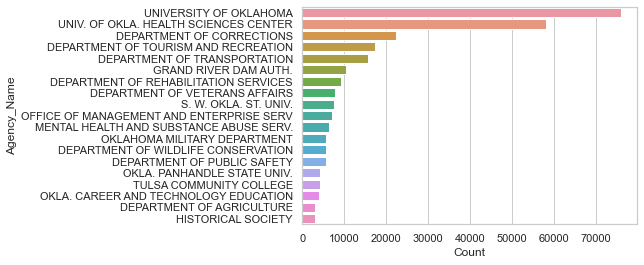

In [7]:
import numpy as np
import plotly
import pandas as pd
import plotly.express as px

# Summarize the count statistics by agency_name in df_count
df_count = df['Agency_Name'].value_counts()
df_count = pd.DataFrame(df_count).reset_index()
df_count.columns = ['Agency_Name','Count']

fig = px.bar(df_count, x='Agency_Name', y='Count', color = 'Agency_Name', width=1000, height=400)
import seaborn as sns
sns.set_theme(style="whitegrid")
sns.barplot(y="Agency_Name", x="Count", data=df_count[1:20])

## Section 3 Feature Engineering <a class="anchor" id="3"></a>

#### Instructions:
- Understand the data grain: each row is a cardholder (last name + first name)
- An agency can have multiple cardholders. A corporate card (agency_name) can be used by many cardholders and these cardholders have to follow the corporation policy.
- Intuition: One or two cardholders may abuse their corporate cards. If we compare a cardholder to his agency, we can find outliers.
- The spending for a merchant category can be higher than others. It does not make sense to compare the spending of a merchant category to another. An agency can spend on various merchant categories, and you cannot claim anomalies just because the spending on one merchant category is higher than another.
- Anomaly detection is about "comparing a transaction to a benchmark". What is the right benchmark? 
- So we will aggregate to the Aggrecy_Name level and card holder level then build features.
- Common sense tells us the comparison should be at "Agency_Name" and "Merchant_Category" level.

###  3.1 Feature 1: The ratio to average amount <a class="anchor" id="31"></a>

In [8]:
# create average spending group by agency and merchant category 
stat_by_agency = df.groupby(['Agency_Name', 'Merchant_Category'])['Amount'].mean()
type(stat_by_agency)
stat_by_agency = pd.DataFrame(stat_by_agency)
stat_by_agency.columns = ['AVG_amount']
stat_by_agency

AVG_amount
Agency_Name                     Merchant_Category                                     
ARDMORE HIGHER EDUCATION CENTER BUSINESS SERVICES NOT ELSEWHERE CLASSIFIED  115.120000
                                CATALOG MERCHANTS                           -53.344286
                                COMPUTER NETWORK/INFORMATION SERVICES        18.340000
                                DRUG STORES AND PHARMACIES                  153.450000
                                GROCERY STORES,AND SUPERMARKETS              74.525455
...                                                                                ...
`DEPARTMENT OF EDUCATION        TELECOMMUNICATION SERVICES                  118.054000
                                TRAVEL AGENCIES                              24.253731
                                TROPICANA RESORT AND CASINO                 481.600000
                                UNITED AIRLINES                             310.547368
                                WYNDHAM HOTELS                               93.282857

[8427 rows x 1 columns]

In [9]:
# add the new feature average spending to the dataset 
df1 = pd.merge(df, stat_by_agency, how='left', on=['Agency_Name', 'Merchant_Category'])
# Feature 1: ratio of amount spending and avergae spending by merchant category 
df1['agency_merchant_avg_ratio_amount'] = np.where(df1['AVG_amount']==0, 0, df1['Amount'] / df1['AVG_amount'])
df1['agency_merchant_avg_ratio_amount'].describe()

count    442458.000000
mean          0.999724
std           7.225363
min       -2735.680000
25%           0.177145
50%           0.515301
75%           1.102916
max        2735.680000
Name: agency_merchant_avg_ratio_amount, dtype: float64

#### My thought process:
- The above percentile motivates me to cut by percentile for plotting
- Do you notice some transactions can be 2 times of the average. Could they be anomalies?

In [54]:
# cut by percentile for plotting
var = 'agency_merchant_avg_ratio_amount'
binned_var = var + '_D'
percentile = [0,0.01,0.05,0.2,0.5,0.8,0.95,0.99,1]
df1[binned_var] = pd.qcut(df1[var],percentile)
df1[['agency_merchant_avg_ratio_amount_D']]

,agency_merchant_avg_ratio_amount_D
0,"(1.298, 3.515]"
1,"(0.515, 1.298]"
2,"(0.133, 0.515]"
3,"(1.298, 3.515]"
4,"(0.133, 0.515]"
...,...
442453,"(0.515, 1.298]"
442454,"(0.133, 0.515]"
442455,"(0.0212, 0.133]"
442456,"(8.71, 2735.68]"


<AxesSubplot:xlabel='agency_merchant_avg_ratio_amount_D', ylabel='count'>

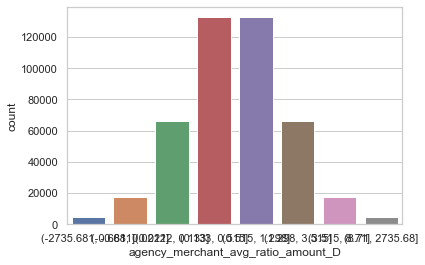

In [55]:
sns.countplot(x="agency_merchant_avg_ratio_amount_D", data=df1)

#### Thought process:
- It will be ideal if the x label does not overlap with each other.
- Try to rotate it.

[Text(0, 0, '(-2735.681, -0.681]'),
 Text(1, 0, '(-0.681, 0.0212]'),
 Text(2, 0, '(0.0212, 0.133]'),
 Text(3, 0, '(0.133, 0.515]'),
 Text(4, 0, '(0.515, 1.298]'),
 Text(5, 0, '(1.298, 3.515]'),
 Text(6, 0, '(3.515, 8.71]'),
 Text(7, 0, '(8.71, 2735.68]')]

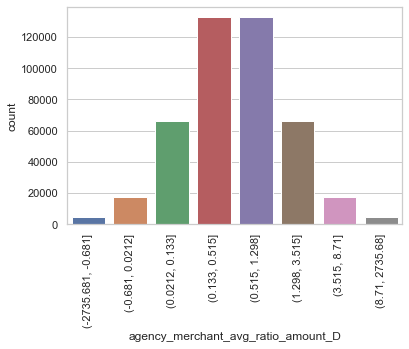

In [56]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
g = sns.countplot(x="agency_merchant_avg_ratio_amount_D", data=df1)
g.set_xticklabels(g.get_xticklabels(), rotation=90)

#### Thought process:
- Now we have identified extreme spending compared to the same merchant category. 
- Take a look of them.

In [57]:
df1[df1['agency_merchant_avg_ratio_amount']>2].head()

,Year_Month,Agency_Number,Agency_Name,Cardholder_Last_Name,Cardholder_First_Initial,Description,Amount,Vendor,Transaction_Date,Posted_Date,Merchant_Category,Year,Month,Week_Number,Day_of_Week,AVG_amount,agency_merchant_avg_ratio_amount,agency_merchant_avg_ratio_amount_D
0,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,GENERAL PURCHASE,890.00,NACAS,2013-07-30,2013-07-31,CHARITABLE AND SOCIAL SERVICE ORGANIZATIONS,2013,7,31,Tuesday,427.634060,2.081219,"(1.298, 3.515]"
16,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Mohiuddin,I,GENERAL PURCHASE,2425.00,WESTERN EQUIPMENT ALVA,2013-07-29,2013-07-31,HARDWARE STORES,2013,7,31,Monday,170.060436,14.259636,"(8.71, 2735.68]"
17,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Mohiuddin,I,GENERAL PURCHASE,2425.00,WESTERN EQUIPMENT ALVA,2013-07-29,2013-07-31,HARDWARE STORES,2013,7,31,Monday,170.060436,14.259636,"(8.71, 2735.68]"
33,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Gerlt,T,GENERAL PURCHASE,3582.00,TELVENT,2013-07-26,2013-07-29,BUSINESS SERVICES NOT ELSEWHERE CLASSIFIED,2013,7,30,Friday,392.641168,9.122833,"(8.71, 2735.68]"
35,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,GODSEY,R,GENERAL PURCHASE,407.85,OPTIMUM ENERGY PROD,2013-07-26,2013-07-29,HARDWARE STORES,2013,7,30,Friday,170.060436,2.398265,"(1.298, 3.515]"


###  3.2 Feature 2: The ratio to the median amount <a class="anchor" id="32"></a>
- Notice the only difference to the above code is "median".

In [95]:
# create average spending group by agency and merchant category 
stat_by_agency = df.groupby(['Agency_Name', 'Merchant_Category'])['Amount'].median() 
stat_by_agency = pd.DataFrame(stat_by_agency)
stat_by_agency.columns = ['Median_amount']

In [96]:
# add the new feature average spending to the dataset 
df2 = pd.merge(df, stat_by_agency, how='left', on=['Agency_Name', 'Merchant_Category'])
# Feature 1: ratio of amount spending and avergae spending by merchant category 
df2['agency_merchant_median_ratio_amount'] = np.where(df2['Median_amount']==0,0, df2['Amount'] / df2['Median_amount'])
df2['agency_merchant_median_ratio_amount'].describe()

count    442458.000000
mean          4.952685
std        1078.581350
min       -1003.176471
25%           0.466090
50%           1.000000
75%           2.121102
max      528116.052705
Name: agency_merchant_median_ratio_amount, dtype: float64

In [97]:
# cut by percentile for plotting
var = 'agency_merchant_median_ratio_amount'
binned_var = var + '_D'
percentile = [0,0.01,0.05,0.2,0.5,0.8,0.95,0.99,1]
df2[binned_var] = pd.qcut(df2[var],percentile)

[Text(0, 0, '(-1003.177, -1.121]'),
 Text(1, 0, '(-1.121, 0.0653]'),
 Text(2, 0, '(0.0653, 0.362]'),
 Text(3, 0, '(0.362, 1.0]'),
 Text(4, 0, '(1.0, 2.691]'),
 Text(5, 0, '(2.691, 9.283]'),
 Text(6, 0, '(9.283, 28.085]'),
 Text(7, 0, '(28.085, 528116.053]')]

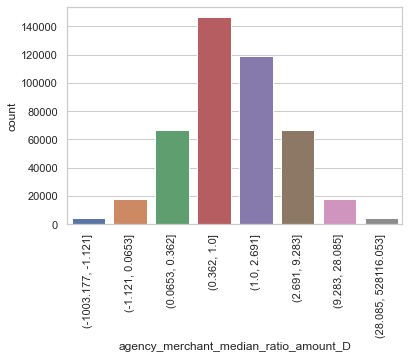

In [98]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
g = sns.countplot(x="agency_merchant_median_ratio_amount_D", data=df2)
g.set_xticklabels(g.get_xticklabels(), rotation=90)

In [100]:
df2[df2['agency_merchant_median_ratio_amount']>2].head()

,Year_Month,Agency_Number,Agency_Name,Cardholder_Last_Name,Cardholder_First_Initial,Description,Amount,Vendor,Transaction_Date,Posted_Date,Merchant_Category,Year,Month,Week_Number,Day_of_Week,Median_amount,agency_merchant_median_ratio_amount,agency_merchant_median_ratio_amount_D
0,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,GENERAL PURCHASE,890.00,NACAS,2013-07-30,2013-07-31,CHARITABLE AND SOCIAL SERVICE ORGANIZATIONS,2013,7,31,Tuesday,250.000,3.560000,"(2.691, 9.283]"
3,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Massey,T,GENERAL PURCHASE,96.39,WAL-MART #0137,2013-07-30,2013-07-31,"GROCERY STORES,AND SUPERMARKETS",2013,7,31,Tuesday,32.485,2.967216,"(2.691, 9.283]"
5,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Mauro-Herrera,M,GENERAL PURCHASE,394.28,KYOCERA DOCUMENT SOLUTION,2013-07-29,2013-07-31,"OFFICE, PHOTOGRAPHIC, PHOTOCOPY, AND MICROFILM...",2013,7,31,Monday,181.940,2.167088,"(1.0, 2.691]"
12,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,McLemore,A,GENERAL PURCHASE,572.27,GIDDINGS MACHINE CO.,2013-07-30,2013-07-31,"COMMERCIAL EQUIPMENT, NOT ELSEWHERE CLASSIFIED",2013,7,31,Tuesday,187.000,3.060267,"(2.691, 9.283]"
14,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Meints,K,GENERAL PURCHASE,445.00,OK DEPT OF VO-TECH ED,2013-07-30,2013-07-31,GOVERNMENT SERVICES--NOT ELSEWHERE CLASSIFIED,2013,7,31,Tuesday,91.500,4.863388,"(2.691, 9.283]"


##### Questions for you:
- You have created two features. Can you create more? How about by agency + merchant category + month?
- You have features in df1, df2, df3, etc. Can you merge the features into one data frame so in the future you can do modeling?